# Scenario 1: All modalities exists, no heterginity

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import seaborn as sns
import networkx as nx

Data Overview:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   0.421776   0.574011   0.599583   0.479369   0.509436   0.519414   
1   0.086067   0.148184   0.152437   0.115488   0.161196   0.144720   
2   0.280018   0.396211   0.411088   0.327705   0.365325   0.362988   
3   0.044752   0.091481   0.096576   0.066178   0.111749   0.093948   
4   0.435670   0.591882   0.617901   0.494919   0.525206   0.535559   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_248  Feature_249  \
0   0.574690   0.495442   0.531326    0.494106  ...     3.955962    -2.599507   
1   0.154916   0.172746   0.145424    0.130367  ...     1.416205     2.409825   
2   0.399500   0.365175   0.371011    0.344062  ...    -1.774577     0.417372   
3   0.097663   0.119082   0.093101    0.079053  ...     1.845771    -6.682148   
4   0.592540   0.511974   0.548630    0.510616  ...    -1.638498     0.237464   

   Feature_250  Feature_251  Feature_252  Feature_253  Feature_254  \
0

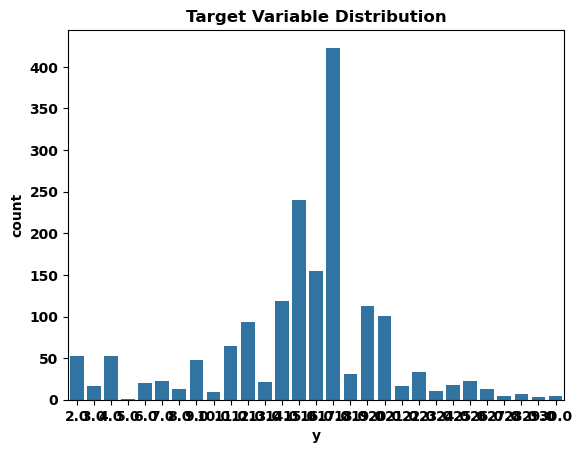

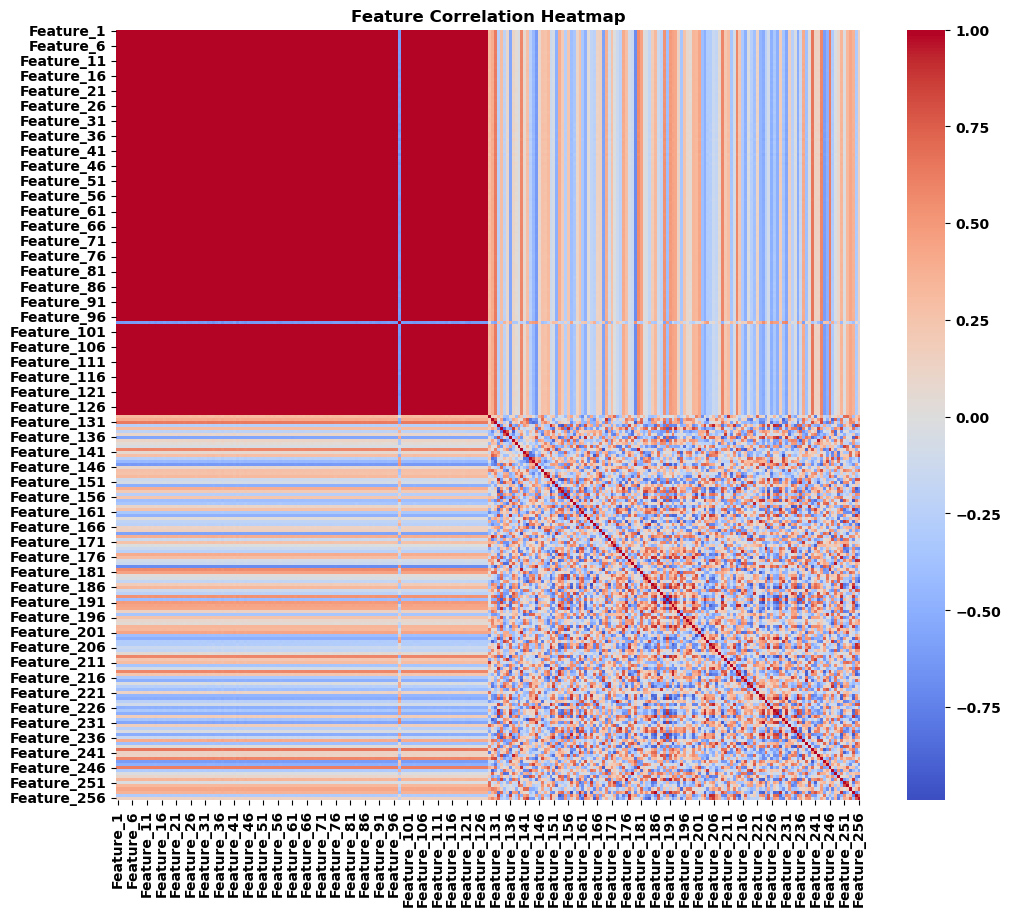

In [2]:
# Set random seed for reproducibility
seed = 42  # You can choose any integer here

# Set seed for NumPy
np.random.seed(seed)

# Set seed for Python's random module
random.seed(seed)

# Set seed for PyTorch
torch.manual_seed(seed)

# For GPU (if using CUDA)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# Set deterministic behavior for reproducibility in case of CUDA operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False






# Directory containing the saved CSV files
output_dir = "datasets/training_outputs/"

# Load one of the CSV files for EDA (e.g., user_0_outputs.csv)
csv_file = os.path.join(output_dir, "user_1_outputs.csv")
df = pd.read_csv(csv_file)

# Quick overview of the data
print("Data Overview:")
print(df.head())
print("\nData Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Distribution of the target variable (y)
sns.countplot(x="y", data=df)
plt.title("Target Variable Distribution")
plt.show()

# Correlation heatmap of features
correlation_matrix = df.iloc[:, :-1].corr()  # Exclude the target column
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [10]:
no_users = 20
# Define the Multinomial Logistic Regression model
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultinomialLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

# Custom dataset to load the data from CSV
class CustomDataset(Dataset):
    def __init__(self,  csv_file, modality=["pos_height", "images"], scaler=None):
        self.data = pd.read_csv(csv_file)
        if "images" in modality and "pos_height" in modality:
            self.X = self.data.iloc[:, :-1].values  # Features
        elif "images" in modality:
            self.X = self.data.iloc[:, 128:-1].values  # Features
        else:
            self.X = self.data.iloc[:, 0:128].values  # Features

        self.y = self.data.iloc[:, -1].values   # Labels

        # If a scaler is provided, use it to transform the features
        if scaler:
            self.X = scaler.transform(self.X)
        else:
            # Fit the scaler on the training data and transform
            self.scaler = MinMaxScaler(feature_range=(-1, 1))
            self.X = self.scaler.fit_transform(self.X)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)  # Use long for classification targets
        return X, y



In [11]:
# Model Preperation#
all_models = []
available_modalities = ["pos_height", "images"]
user_modalities = [available_modalities for _ in range(no_users)]
modality_size = {"pos_height": 128, "images": 128}
output_sizes = [sum([modality_size[i] for i in user_modality]) for user_modality in user_modalities]


In [12]:
no_users = 20
# List to store DataLoader objects for each user
train_loaders = []
val_loaders = []
test_loaders = []
scaler = None
# Loop over each user
dataset_dir = "datasets/"
for user_idx in range(no_users):
    # Define file paths for each user dynamically
    train_file = dataset_dir + f"training_outputs/user_{user_idx}_outputs.csv"
    val_file = dataset_dir + f"val_outputs/user_{user_idx}_outputs.csv"
    test_file = dataset_dir + f"test_outputs/user_{user_idx}_outputs.csv"

    # Load training data and fit the scaler on it (only once for each user)
    train_data = pd.read_csv(train_file)
    
    if scaler is None:
        # Fit the scaler on the first user's training data
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(train_data.iloc[:, :-1].values)  # Fit scaler only on training features

    # Create datasets using the same scaler for all data
    train_dataset = CustomDataset(train_file, scaler=scaler, modality=user_modalities[user_idx])
    val_dataset = CustomDataset(val_file, scaler=scaler)
    test_dataset = CustomDataset(test_file, scaler=scaler)

    # Create DataLoader for training, validation, and testing for each user
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Append each user's DataLoader to the respective lists
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)
    test_loaders.append(test_loader)

In [13]:
# Initialize model, loss function, and optimizer for multiple users
input_sizes = output_sizes  # Number of features
num_classes = 64
classifiers = [MultinomialLogisticRegression(input_size, num_classes) for input_size, _ in zip(input_sizes, range(no_users))]
#classifiers = [MultinomialLogisticRegression(input_size, num_classes).cuda() for _ in range(no_users)]
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in classifiers]
criterion = nn.CrossEntropyLoss()
# Training parameters
num_epochs = 100

In [14]:
# Create a dictionary to store similarity matrices for each modality
similarity_matrices = {modality: np.zeros((no_users, no_users), dtype=int) for modality in available_modalities}

# Populate the similarity matrices
for modality in available_modalities:
    for i in range(no_users):
        for j in range(no_users):
            if modality in user_modalities[i] and modality in user_modalities[j]:
                similarity_matrices[modality][i, j] = 1

# Print the resulting matrices
for modality, matrix in similarity_matrices.items():
    print(f"Similarity Matrix for '{modality}':")
    print(matrix)

Similarity Matrix for 'pos_height':
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
Similarity Matrix for 'images':
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 

In [15]:
def sinkhorn_knopp(matrix, tol=1e-9, max_iter=1000):
    """
    Converts a given matrix to a doubly stochastic matrix using the Sinkhorn-Knopp algorithm.
    
    Parameters:
        matrix (np.ndarray): The input matrix to be transformed.
        tol (float): The tolerance for convergence.
        max_iter (int): Maximum number of iterations for convergence.
    
    Returns:
        np.ndarray: A doubly stochastic matrix.
    """
    matrix = matrix.copy()
    for _ in range(max_iter):
        # Normalize rows
        row_sums = matrix.sum(axis=1, keepdims=True)
        matrix /= row_sums

        # Normalize columns
        col_sums = matrix.sum(axis=0, keepdims=True)
        matrix /= col_sums

        # Check for convergence
        if np.allclose(matrix.sum(axis=1), 1, atol=tol) and np.allclose(matrix.sum(axis=0), 1, atol=tol):
            break

    return matrix
    
def create_random_topology(num_users, edge_probability=0.3):
    """
    Creates a connected random topology using NetworkX.
    Returns the adjacency matrix.
    """
    while True:
        graph = nx.erdos_renyi_graph(num_users, edge_probability)
        if nx.is_connected(graph):
            break

    # Convert graph to adjacency matrix
    adjacency_matrix = nx.to_numpy_array(graph)
    return adjacency_matrix

def prepare_mixing_matrices(adjacency_matrix, similarity_matrices):
    """
    Computes a mixing matrix for each modality by multiplying the adjacency matrix 
    with the similarity matrix for that modality.
    Returns a dictionary of mixing matrices.
    """
    adjacency_matrices = {}
    mixing_matrices = {}
    for modality, similarity_matrix in similarity_matrices.items():
        # Element-wise multiplication of adjacency and similarity matrices
        combined_matrix = adjacency_matrix * similarity_matrix
        adjacency_matrices[modality] = combined_matrix
        
        # Normalize to create a doubly matrix
        mixing_matrix = sinkhorn_knopp(combined_matrix)
        
        
        mixing_matrices[modality] = mixing_matrix
    
    return mixing_matrices, adjacency_matrices




In [16]:
# Create random connected topology
adjacency_matrix = create_random_topology(no_users, edge_probability=0.3)

# Prepare mixing matrices for each modality
mixing_matrices, adjacency_matrices = prepare_mixing_matrices(adjacency_matrix, similarity_matrices)


# Local_Training

In [35]:



# Model Preperation#
all_models = []
available_modalities = ["pos_height", "images"]
user_modalities = [available_modalities for _ in range(no_users)]
modality_size = {"pos_height": 128, "images": 128}
output_sizes = [sum([modality_size[i] for i in user_modality]) for user_modality in user_modalities]

#local_classifiers = [MultinomialLogisticRegression(output_sizes[i], 64).cuda() for i in range(no_users)]
local_classifiers = [MultinomialLogisticRegression(output_sizes[i], 64) for i in range(no_users)]

    

In [36]:
factor = 0.1
neighbors = [np.nonzero(adjacency_matrix[i])[0].tolist() for i in range(no_users)]

# Initialize P_ij matrices
# Initialize P_ij matrices
P = {}
for i, j in zip(*adjacency_matrix.nonzero()):
    num_params_i = sum(p.numel() for p in local_classifiers[i].parameters())
    num_params_j = sum(p.numel() for p in local_classifiers[j].parameters())
    P[(i, j)] = torch.randn(int(factor*(num_params_i + num_params_j) // 2), num_params_i)#.cuda()
    P[(j, i)] = torch.randn(int(factor*(num_params_i + num_params_j) // 2), num_params_j)#.cuda()


In [38]:
def validate_user_model_FMTL(user_id, user_models, client_model, val_loader, loss_func):


    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Disable gradient computation for validation
    with torch.no_grad():
        # Set all models to evaluation mode
        client_model.eval()
        for model in user_models.values():
            model.eval()

        for X_batch, y_batch in val_loader:
            # Concatenate outputs from all modality models
            modality_outputs = []
            y_batch = y_batch.cuda()

            for modality, model in user_models.items():

                # Forward pass through modality model
                data = X_batch[modality].cuda()
                modality_output, _ = model(data)
                modality_outputs.append(modality_output)

            # Skip if no valid modalities are present
            if len(modality_outputs) == 0:
                print(f"No valid modalities for User {user_id + 1}, skipping batch.")
                continue

            # Concatenate all modality outputs
            concatenated_output = torch.cat(modality_outputs, dim=1)

            # Forward pass through the classifier
            predictions = client_model(concatenated_output)

            # Compute loss
            loss = loss_func(client_model, concatenated_output, y_batch, l2_strength=0.01)
            total_loss += loss.item() * y_batch.size(0)

            # Compute accuracy
            _, predicted = torch.max(predictions, 1)
            total_correct += (predicted == y_batch).sum().item()
            total_samples += y_batch.size(0)

    # Compute overall metrics
    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    print(f"User {user_id + 1} - Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return {'loss': avg_loss, 'accuracy': accuracy}


In [39]:
local_epochs = 1
global_rounds = 100
weight_decay = 1e-5
criterion = nn.CrossEntropyLoss()
loss_func = cross_entropy_loss_with_l2
alpha = 0.001
lambda_reg = 0.01
eta = 0.01
# Track metrics across all users
train_loss_histories = []
val_loss_histories = []
train_accuracy_histories = []
val_accuracy_histories = []

# Decentralized Training
for epoch in range(global_rounds):
    print(f"Global Round {epoch + 1}")
    user_train_losses = []
    user_val_losses = []
    user_train_accuracies = []
    user_val_accuracies = []
    
    # FMTL Training Part
    print("Performing FMTL aggregation")
    for i in range(no_users):
        epoch_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0
        client_model = local_classifiers[i]

        optimizer = optim.Adam(client_model.parameters(), lr=alpha)
        
        # Training the model
        client_model.train()
        for X_batch, y_batch in train_loaders[i]:

            # Forward pass through the classifier
            optimizer.zero_grad()
            predictions = client_model(X_batch)
            
                    
            # Compute the loss
            loss = criterion(predictions, y_batch)#loss_func(client_model, X_batch, y_batch, l2_strength=0.01)
        
            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            _, predicted = torch.max(predictions, dim=1)
            correct_train_predictions += (predicted == y_batch).sum().item()
            total_train_samples += y_batch.size(0)
        
    
        with torch.no_grad():
            theta_i = torch.cat([param.view(-1) for param in client_model.parameters()])
    
            # Update theta_i based on P_ij and neighbors
            sum_P_terms = torch.zeros_like(theta_i)
            for j in range(no_users):
                if adjacency_matrix[i, j] == 1:
                    P_ij = P[(i, j)]
                    P_ji = P[(j, i)]
                    theta_j = torch.cat([param.view(-1) for param in local_classifiers[j].parameters()])
                    sum_P_terms += P_ij.T @ (P_ij @ theta_i - P_ji @ theta_j)
    
            # Apply update to theta_i
            theta_i -= alpha * lambda_reg * sum_P_terms
    
            # Put updated theta_i back into the model
            idx = 0
            for param in client_model.parameters():
                numel = param.numel()
                param.data.copy_(theta_i[idx:idx+numel].reshape(param.size()))
                idx += numel
    
            # Update P_ij matrices
            for j in range(no_users):
                if adjacency_matrix[i, j] == 1:
                    P_ij = P[(i, j)]
                    P_ji = P[(j, i)]
                    theta_j = torch.cat([param.view(-1) for param in local_classifiers[j].parameters()])
    
                    # Update P_ij
                    P[(i, j)] -= eta * lambda_reg * torch.outer(P_ij @ theta_i - P_ji @ theta_j, theta_i)
        

        avg_train_loss = epoch_train_loss / len(train_loaders[i])
        train_accuracy = correct_train_predictions / total_train_samples

        # Validation phase

        epoch_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0
        client_model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loaders[i]:  # Assuming val_loader is a list of loaders for users
                #X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                outputs = client_model(X_batch)
                loss = criterion(outputs, y_batch)

                epoch_val_loss += loss.item()
                _, predicted = torch.max(outputs, dim=1)
                correct_val_predictions += (predicted == y_batch).sum().item()
                total_val_samples += y_batch.size(0)

        avg_val_loss = epoch_val_loss / len(val_loaders[i])
        val_accuracy = correct_val_predictions / total_val_samples

        user_train_losses.append(avg_train_loss)
        user_train_accuracies.append(train_accuracy)
        user_val_losses.append(avg_val_loss)
        user_val_accuracies.append(val_accuracy)

    # Store the averages and standard deviations across users
    train_loss_histories.append(user_train_losses)
    train_accuracy_histories.append(user_train_accuracies)
    val_loss_histories.append(user_val_losses)
    val_accuracy_histories.append(user_val_accuracies)

    # Print average metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Train Loss: {np.mean(user_train_losses):.4f}, Avg Train Accuracy: {np.mean(user_train_accuracies):.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Val Loss: {np.mean(user_val_losses):.4f}, Avg Val Accuracy: {np.mean(user_val_accuracies):.4f}")




Global Round 1
Performing FMTL aggregation


C:\Users\aghalkha21\AppData\Local\Temp\ipykernel_40572\1463351336.py:37: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[idx], dtype=torch.long)  # Use long for classification targets


Epoch [1/100], Avg Train Loss: 2.8615, Avg Train Accuracy: 0.3979
Epoch [1/100], Avg Val Loss: 2.0052, Avg Val Accuracy: 0.6083
Global Round 2
Performing FMTL aggregation
Epoch [2/100], Avg Train Loss: 1.5182, Avg Train Accuracy: 0.6731
Epoch [2/100], Avg Val Loss: 1.3017, Avg Val Accuracy: 0.7141
Global Round 3
Performing FMTL aggregation
Epoch [3/100], Avg Train Loss: 1.0961, Avg Train Accuracy: 0.7306
Epoch [3/100], Avg Val Loss: 1.0314, Avg Val Accuracy: 0.7471
Global Round 4
Performing FMTL aggregation
Epoch [4/100], Avg Train Loss: 0.9161, Avg Train Accuracy: 0.7593
Epoch [4/100], Avg Val Loss: 0.8992, Avg Val Accuracy: 0.7652
Global Round 5
Performing FMTL aggregation
Epoch [5/100], Avg Train Loss: 0.8185, Avg Train Accuracy: 0.7769
Epoch [5/100], Avg Val Loss: 0.8215, Avg Val Accuracy: 0.7775
Global Round 6
Performing FMTL aggregation
Epoch [6/100], Avg Train Loss: 0.7571, Avg Train Accuracy: 0.7899
Epoch [6/100], Avg Val Loss: 0.7702, Avg Val Accuracy: 0.7884
Global Round 7
Pe

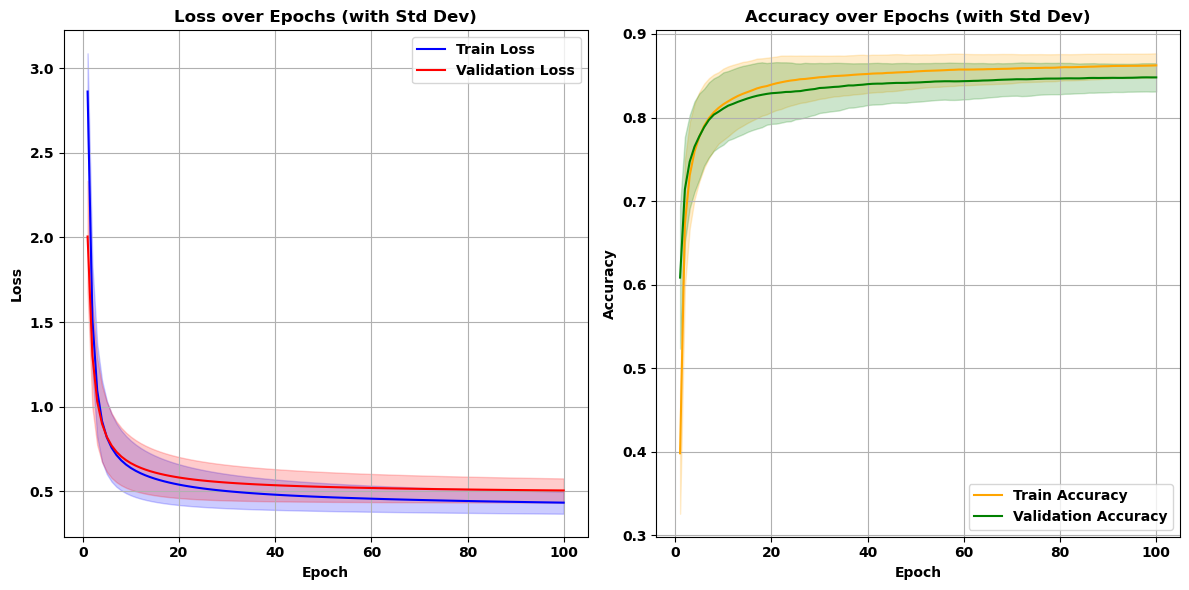

In [43]:
# Convert metrics to numpy arrays for easy manipulation
train_loss_histories = np.array(train_loss_histories)
train_accuracy_histories = np.array(train_accuracy_histories)
val_loss_histories = np.array(val_loss_histories)
val_accuracy_histories = np.array(val_accuracy_histories)

# Calculate means and standard deviations
train_loss_mean = train_loss_histories.mean(axis=1)
train_loss_std = train_loss_histories.std(axis=1)
val_loss_mean = val_loss_histories.mean(axis=1)
val_loss_std = val_loss_histories.std(axis=1)

train_acc_mean = train_accuracy_histories.mean(axis=1)
train_acc_std = train_accuracy_histories.std(axis=1)
val_acc_mean = val_accuracy_histories.mean(axis=1)
val_acc_std = val_accuracy_histories.std(axis=1)

# Plot metrics
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_mean, label="Train Loss", color="blue")
plt.fill_between(range(1, num_epochs + 1), train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, color="blue", alpha=0.2)
plt.plot(range(1, num_epochs + 1), val_loss_mean, label="Validation Loss", color="red")
plt.fill_between(range(1, num_epochs + 1), val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, color="red", alpha=0.2)
plt.title("Loss over Epochs (with Std Dev)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_mean, label="Train Accuracy", color="orange")
plt.fill_between(range(1, num_epochs + 1), train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, color="orange", alpha=0.2)
plt.plot(range(1, num_epochs + 1), val_acc_mean, label="Validation Accuracy", color="green")
plt.fill_between(range(1, num_epochs + 1), val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, color="green", alpha=0.2)
plt.title("Accuracy over Epochs (with Std Dev)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

C:\Users\aghalkha21\AppData\Local\Temp\ipykernel_40572\1463351336.py:37: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[idx], dtype=torch.long)  # Use long for classification targets



Average Test Loss: 0.5179, Average Test Accuracy: 0.8410

Average Train Loss: 0.4139, Average Train Accuracy: 0.8699


C:\Users\aghalkha21\AppData\Local\Temp\ipykernel_40572\381433634.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_loss_histories[-1], test_loss_histories[-1]], labels=["Train Loss", "Test Loss"])
C:\Users\aghalkha21\AppData\Local\Temp\ipykernel_40572\381433634.py:101: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_accuracy_histories[-1], test_accuracy_histories[-1]], labels=["Train Accuracy", "Test Accuracy"])


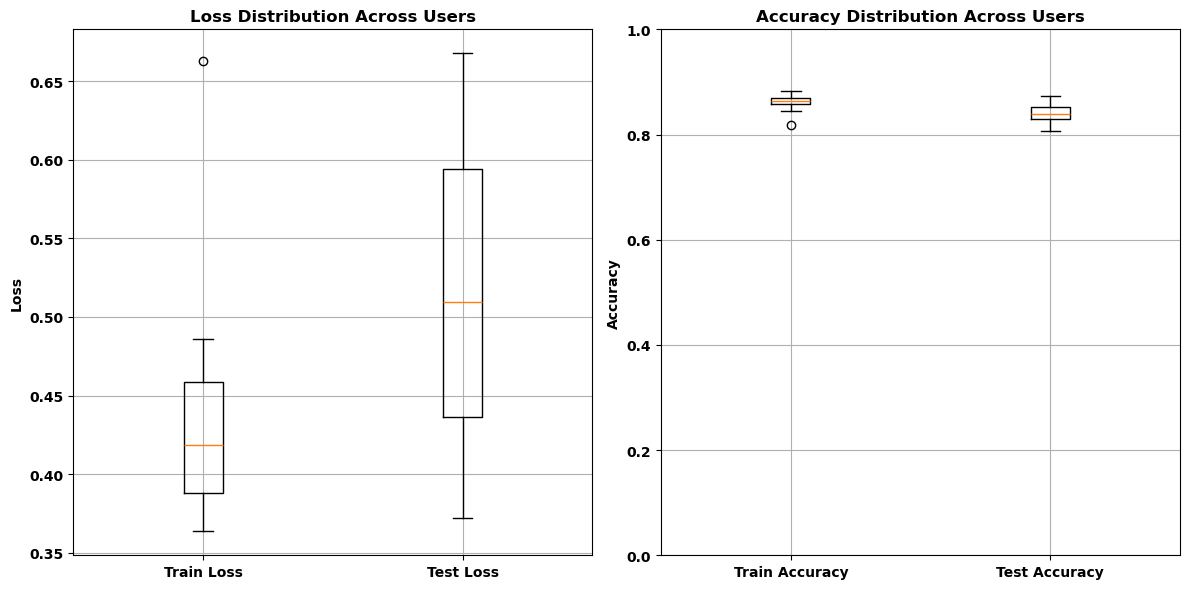

In [46]:
# Track metrics across all users
test_loss_histories = []
test_accuracy_histories = []
#train_loss_histories = []
#train_accuracy_histories = []

# Testing loop for all users
user_test_losses = []
user_test_accuracies = []
user_train_losses = []
user_train_accuracies = []

with torch.no_grad():  # Disable gradient computation for testing
    for user_id, model in enumerate(local_classifiers):
        model.eval()

        # Test metrics
        epoch_test_loss = 0.0
        correct_test_predictions = 0
        total_test_samples = 0

        # Train metrics (optional, for post-training evaluation on training data)
        epoch_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0

        # Evaluate on test set
        for X_batch, y_batch in test_loaders[user_id]:  # Assuming test_loader is a list of loaders for users
            #X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            epoch_test_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct_test_predictions += (predicted == y_batch).sum().item()
            total_test_samples += y_batch.size(0)
        # Evaluate on training set
        for X_batch, y_batch in train_loaders[user_id]:  # Assuming train_loader is available per user
            #X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct_train_predictions += (predicted == y_batch).sum().item()
            total_train_samples += y_batch.size(0)

        # Calculate averages
        avg_test_loss = epoch_test_loss / len(test_loaders[user_id])
        test_accuracy = correct_test_predictions / total_test_samples

        avg_train_loss = epoch_train_loss / len(train_loaders[user_id])
        train_accuracy = correct_train_predictions / total_train_samples

        # Store metrics for each user
        user_test_losses.append(avg_test_loss)
        user_test_accuracies.append(test_accuracy)
        user_train_losses.append(avg_train_loss)
        user_train_accuracies.append(train_accuracy)


# Store the average metrics across all users
test_loss_histories.append(user_test_losses)
test_accuracy_histories.append(user_test_accuracies)
#train_loss_histories.append(user_train_losses)
#train_accuracy_histories.append(user_train_accuracies)

# Print average metrics
print(f"\nAverage Test Loss: {np.mean(user_test_losses):.4f}, Average Test Accuracy: {np.mean(user_test_accuracies):.4f}")
print(f"\nAverage Train Loss: {np.mean(user_train_losses):.4f}, Average Train Accuracy: {np.mean(user_train_accuracies):.4f}")

# Convert metrics to numpy arrays for plotting
test_loss_histories = np.array(test_loss_histories)
test_accuracy_histories = np.array(test_accuracy_histories)
train_loss_histories = np.array(train_loss_histories)
train_accuracy_histories = np.array(train_accuracy_histories)

# Calculate means and standard deviations
test_loss_mean = test_loss_histories.mean(axis=1)
test_loss_std = test_loss_histories.std(axis=1)
test_acc_mean = test_accuracy_histories.mean(axis=1)
test_acc_std = test_accuracy_histories.std(axis=1)

train_loss_mean = train_loss_histories.mean(axis=1)
train_loss_std = train_loss_histories.std(axis=1)
train_acc_mean = train_accuracy_histories.mean(axis=1)
train_acc_std = train_accuracy_histories.std(axis=1)

# Box plot for final train and test loss
plt.figure(figsize=(12, 6))

# Loss box plot
plt.subplot(1, 2, 1)
plt.boxplot([train_loss_histories[-1], test_loss_histories[-1]], labels=["Train Loss", "Test Loss"])
plt.title("Loss Distribution Across Users")
plt.ylabel("Loss")
plt.grid()

# Accuracy box plot
plt.subplot(1, 2, 2)
plt.boxplot([train_accuracy_histories[-1], test_accuracy_histories[-1]], labels=["Train Accuracy", "Test Accuracy"])
plt.title("Accuracy Distribution Across Users")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Ensure y-axis is between 0 and 1 for accuracy
plt.grid()

plt.tight_layout()
plt.show()



In [ ]:
import json

metrics = {
    "FMTL_train_loss_histories": train_loss_histories.tolist(),
    "FMTL_train_accuracy_histories": train_accuracy_histories.tolist(),
    "FMTL_val_loss_histories": val_loss_histories.tolist(),
    "FMTL_val_accuracy_histories": val_accuracy_histories.tolist(),
    "FMTL_test_loss_histories": test_loss_histories.tolist(),
    "FMTL_test_accuracy_histories": test_accuracy_histories.tolist(),
}

with open("metrics.json", "w") as f:
    json.dump(metrics, f)
print("FMTL_metrics.json")

In [ ]:
# Load metrics from JSON file
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Convert lists back to numpy arrays
train_loss_histories = np.array(metrics["train_loss_histories"])
train_accuracy_histories = np.array(metrics["train_accuracy_histories"])
val_loss_histories = np.array(metrics["val_loss_histories"])
val_accuracy_histories = np.array(metrics["val_accuracy_histories"])
test_loss_histories = np.array(metrics["test_loss_histories"])
test_accuracy_histories = np.array(metrics["test_accuracy_histories"])
# Print shapes to confirm loading
print("Train Loss Histories Shape:", train_loss_histories.shape)
print("Train Accuracy Histories Shape:", train_accuracy_histories.shape)
print("Validation Loss Histories Shape:", val_loss_histories.shape)
print("Validation Accuracy Histories Shape:", val_accuracy_histories.shape)
print("Test Loss Histories Shape:", test_loss_histories.shape)
print("Test Accuracy Histories Shape:", test_accuracy_histories.shape)